In [1]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

import energyflow as ef
import torch
import torch.nn as nn

In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

In [3]:
from graph_data import GraphDataset
gdata = GraphDataset(root='/home/jovyan/.energyflow/datasets/')

Processing...
Done!


In [4]:
print(gdata[5].u)
print(gdata[5].y)
print(gdata[5].edge_index)
print(sum(gdata[5].x[0:18,0]))
len(gdata)

tensor([[5.0082, 4.9424]])
tensor([[2.2362]])
tensor([[ 0,  0,  0,  ..., 17, 17, 17],
        [18, 19, 20,  ..., 76, 77, 78]])
tensor(1.)


10000

In [5]:
from models import DynamicEdgeNet, EdgeNet

In [6]:
input_dim = 3
big_dim = 32
bigger_dim = 128
global_dim = 2
output_dim = 1
fulllen = len(gdata)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
batch_size = 128
lr = 0.001
device = 'cuda:0'
model_fname = 'DynamicEdgeNet'

model = DynamicEdgeNet(input_dim=input_dim, big_dim=big_dim, bigger_dim=bigger_dim, 
                global_dim=global_dim, output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [7]:
from torch_geometric.data import Data, DataLoader
from torch.utils.data import random_split
train_dataset, valid_dataset, test_dataset = random_split(gdata, [fulllen-2*tv_num,tv_num,tv_num])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

print(train_samples)
print(valid_samples)
print(test_samples)


8000
1000
1000


In [8]:
import tqdm
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data)
        batch_loss_item = mse(batch_output, data.y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = mse(batch_output, data.y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [9]:
import os.path as osp

n_epochs = 100
patience = 10
stale_epochs = 0
best_valid_loss = 99999
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, train_loader, train_samples, batch_size)
    valid_loss = test(model, valid_loader, valid_samples, batch_size)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('               Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('/home/jovyan/work/EnergyFlow/demos/',model_fname+'.best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

loss = 0.19037: : 63it [00:43,  1.45it/s]                        
loss = 0.26907:  90%|████████▉ | 7/7.8125 [00:05<00:00,  1.46it/s]/opt/conda/lib/python3.7/site-packages/tqdm/std.py:521: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
loss = 0.26907: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 00, Training Loss:   0.4163
               Validation Loss: 0.2802
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.16295: : 63it [00:43,  1.44it/s]                        
loss = 0.14249: 102%|██████████| 8/7.8125 [00:05<00:00,  1.47it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   0.2177
               Validation Loss: 0.1469
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.08025: : 63it [00:43,  1.45it/s]                        
loss = 0.11425: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 02, Training Loss:   0.1173
               Validation Loss: 0.0976
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.12440: : 63it [00:43,  1.46it/s]                        
loss = 0.10871: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 03, Training Loss:   0.0998
               Validation Loss: 0.0907
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.06855: : 63it [00:43,  1.45it/s]                        
loss = 0.10628: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 04, Training Loss:   0.0906
               Validation Loss: 0.0856
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.04558: : 63it [00:43,  1.46it/s]                        
loss = 0.10391: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 05, Training Loss:   0.0847
               Validation Loss: 0.0801
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.11476: : 63it [00:43,  1.44it/s]                        
loss = 0.09638: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 06, Training Loss:   0.0793
               Validation Loss: 0.0732
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.06339: : 63it [00:43,  1.45it/s]                        
loss = 0.09701: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 07, Training Loss:   0.0747
               Validation Loss: 0.0711
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.06744: : 63it [00:43,  1.44it/s]                        
loss = 0.09882: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 08, Training Loss:   0.0719
               Validation Loss: 0.0711
Stale epoch


loss = 0.12004: : 63it [00:43,  1.44it/s]                        
loss = 0.08622: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 09, Training Loss:   0.0659
               Validation Loss: 0.0618
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.06982: : 63it [00:43,  1.45it/s]                        
loss = 0.07736: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 10, Training Loss:   0.0596
               Validation Loss: 0.0557
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.08709: : 63it [00:43,  1.45it/s]                        
loss = 0.07103: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 11, Training Loss:   0.0550
               Validation Loss: 0.0541
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.04702: : 63it [00:43,  1.46it/s]                        
loss = 0.07027: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 12, Training Loss:   0.0514
               Validation Loss: 0.0516
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02993: : 63it [00:43,  1.45it/s]                        
loss = 0.06499: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 13, Training Loss:   0.0498
               Validation Loss: 0.0458
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.05519: : 63it [00:43,  1.45it/s]                        
loss = 0.07042: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 14, Training Loss:   0.0496
               Validation Loss: 0.0505
Stale epoch


loss = 0.03224: : 63it [00:43,  1.45it/s]                        
loss = 0.06023: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 15, Training Loss:   0.0471
               Validation Loss: 0.0426
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02747: : 63it [00:43,  1.45it/s]                        
loss = 0.06649: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 16, Training Loss:   0.0454
               Validation Loss: 0.0478
Stale epoch


loss = 0.08863: : 63it [00:43,  1.45it/s]                        
loss = 0.05750: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 17, Training Loss:   0.0460
               Validation Loss: 0.0427
Stale epoch


loss = 0.05601: : 63it [00:43,  1.46it/s]                        
loss = 0.05559: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 18, Training Loss:   0.0450
               Validation Loss: 0.0400
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.03750: : 63it [00:43,  1.46it/s]                        
loss = 0.06146: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 19, Training Loss:   0.0427
               Validation Loss: 0.0460
Stale epoch


loss = 0.02240: : 63it [00:43,  1.46it/s]                        
loss = 0.05151: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 20, Training Loss:   0.0442
               Validation Loss: 0.0368
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.06150: : 63it [00:43,  1.45it/s]                        
loss = 0.04904: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 21, Training Loss:   0.0410
               Validation Loss: 0.0368
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02894: : 63it [00:43,  1.46it/s]                        
loss = 0.05347: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 22, Training Loss:   0.0404
               Validation Loss: 0.0407
Stale epoch


loss = 0.01964: : 63it [00:43,  1.45it/s]                        
loss = 0.04860: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 23, Training Loss:   0.0395
               Validation Loss: 0.0374
Stale epoch


loss = 0.02816: : 63it [00:43,  1.45it/s]                        
loss = 0.04732: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 24, Training Loss:   0.0386
               Validation Loss: 0.0348
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02464: : 63it [00:43,  1.44it/s]                        
loss = 0.04564: 102%|██████████| 8/7.8125 [00:05<00:00,  1.42it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 25, Training Loss:   0.0381
               Validation Loss: 0.0350
Stale epoch


loss = 0.04309: : 63it [00:44,  1.40it/s]                        
loss = 0.04776: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 26, Training Loss:   0.0398
               Validation Loss: 0.0386
Stale epoch


loss = 0.02547: : 63it [00:44,  1.41it/s]                        
loss = 0.04338: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 27, Training Loss:   0.0368
               Validation Loss: 0.0344
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.04363: : 63it [00:45,  1.39it/s]                        
loss = 0.04259: 102%|██████████| 8/7.8125 [00:05<00:00,  1.45it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 28, Training Loss:   0.0379
               Validation Loss: 0.0330
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02725: : 63it [00:45,  1.39it/s]                        
loss = 0.04218: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 29, Training Loss:   0.0361
               Validation Loss: 0.0320
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02999: : 63it [00:45,  1.39it/s]                        
loss = 0.04143: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 30, Training Loss:   0.0369
               Validation Loss: 0.0317
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.05855: : 63it [00:44,  1.40it/s]                        
loss = 0.04154: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 31, Training Loss:   0.0354
               Validation Loss: 0.0313
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02422: : 63it [00:45,  1.40it/s]                        
loss = 0.04809: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 32, Training Loss:   0.0339
               Validation Loss: 0.0372
Stale epoch


loss = 0.05243: : 63it [00:45,  1.39it/s]                        
loss = 0.04194: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 33, Training Loss:   0.0352
               Validation Loss: 0.0334
Stale epoch


loss = 0.04051: : 63it [00:45,  1.39it/s]                        
loss = 0.04101: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 34, Training Loss:   0.0374
               Validation Loss: 0.0315
Stale epoch


loss = 0.06236: : 63it [00:45,  1.39it/s]                        
loss = 0.03959: 102%|██████████| 8/7.8125 [00:05<00:00,  1.42it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 35, Training Loss:   0.0358
               Validation Loss: 0.0301
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.04834: : 63it [00:45,  1.40it/s]                        
loss = 0.03853: 102%|██████████| 8/7.8125 [00:05<00:00,  1.41it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 36, Training Loss:   0.0330
               Validation Loss: 0.0294
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.03287: : 63it [00:45,  1.39it/s]                        
loss = 0.03741: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 37, Training Loss:   0.0347
               Validation Loss: 0.0296
Stale epoch


loss = 0.04990: : 63it [00:45,  1.39it/s]                        
loss = 0.03742: 102%|██████████| 8/7.8125 [00:05<00:00,  1.38it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 38, Training Loss:   0.0324
               Validation Loss: 0.0287
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.03214: : 63it [00:45,  1.38it/s]                        
loss = 0.04075: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 39, Training Loss:   0.0321
               Validation Loss: 0.0298
Stale epoch


loss = 0.01987: : 63it [00:45,  1.38it/s]                        
loss = 0.04177: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 40, Training Loss:   0.0319
               Validation Loss: 0.0319
Stale epoch


loss = 0.01659: : 63it [00:45,  1.38it/s]                        
loss = 0.03511: 102%|██████████| 8/7.8125 [00:05<00:00,  1.42it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 41, Training Loss:   0.0332
               Validation Loss: 0.0274
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02285: : 63it [00:45,  1.38it/s]                        
loss = 0.04945: 102%|██████████| 8/7.8125 [00:05<00:00,  1.41it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 42, Training Loss:   0.0309
               Validation Loss: 0.0400
Stale epoch


loss = 0.05157: : 63it [00:45,  1.39it/s]                        
loss = 0.03605: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 43, Training Loss:   0.0344
               Validation Loss: 0.0266
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02139: : 63it [00:43,  1.44it/s]                        
loss = 0.03513: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 44, Training Loss:   0.0312
               Validation Loss: 0.0273
Stale epoch


loss = 0.02450: : 63it [00:43,  1.44it/s]                        
loss = 0.04696: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 45, Training Loss:   0.0306
               Validation Loss: 0.0353
Stale epoch


loss = 0.09573: : 63it [00:44,  1.41it/s]                        
loss = 0.03674: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 46, Training Loss:   0.0317
               Validation Loss: 0.0330
Stale epoch


loss = 0.02468: : 63it [00:44,  1.42it/s]                        
loss = 0.03849: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 47, Training Loss:   0.0299
               Validation Loss: 0.0312
Stale epoch


loss = 0.03948: : 63it [00:43,  1.45it/s]                        
loss = 0.03428: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 48, Training Loss:   0.0310
               Validation Loss: 0.0265
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02612: : 63it [00:43,  1.44it/s]                        
loss = 0.03375: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 49, Training Loss:   0.0306
               Validation Loss: 0.0275
Stale epoch


loss = 0.02585: : 63it [00:43,  1.45it/s]                        
loss = 0.03414: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 50, Training Loss:   0.0307
               Validation Loss: 0.0299
Stale epoch


loss = 0.03428: : 63it [00:43,  1.44it/s]                        
loss = 0.03189: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 51, Training Loss:   0.0293
               Validation Loss: 0.0251
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.04129: : 63it [00:43,  1.45it/s]                        
loss = 0.04312: 102%|██████████| 8/7.8125 [00:05<00:00,  1.45it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 52, Training Loss:   0.0300
               Validation Loss: 0.0384
Stale epoch


loss = 0.05385: : 63it [00:43,  1.45it/s]                        
loss = 0.03296: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 53, Training Loss:   0.0303
               Validation Loss: 0.0248
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.05365: : 63it [00:43,  1.45it/s]                        
loss = 0.03294: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 54, Training Loss:   0.0286
               Validation Loss: 0.0250
Stale epoch


loss = 0.02617: : 63it [00:44,  1.41it/s]                        
loss = 0.04776: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 55, Training Loss:   0.0288
               Validation Loss: 0.0390
Stale epoch


loss = 0.03252: : 63it [00:45,  1.39it/s]                        
loss = 0.02911: 102%|██████████| 8/7.8125 [00:05<00:00,  1.43it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 56, Training Loss:   0.0285
               Validation Loss: 0.0232
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.12664: : 63it [00:45,  1.39it/s]                        
loss = 0.02957: 102%|██████████| 8/7.8125 [00:05<00:00,  1.48it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 57, Training Loss:   0.0299
               Validation Loss: 0.0239
Stale epoch


loss = 0.02565: : 63it [00:43,  1.44it/s]                        
loss = 0.03062: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 58, Training Loss:   0.0275
               Validation Loss: 0.0262
Stale epoch


loss = 0.01483: : 63it [00:43,  1.45it/s]                        
loss = 0.02786: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 59, Training Loss:   0.0276
               Validation Loss: 0.0228
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.06042: : 63it [00:43,  1.45it/s]                        
loss = 0.02880: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 60, Training Loss:   0.0266
               Validation Loss: 0.0238
Stale epoch


loss = 0.03886: : 63it [00:43,  1.45it/s]                        
loss = 0.03507: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 61, Training Loss:   0.0281
               Validation Loss: 0.0345
Stale epoch


loss = 0.02203: : 63it [00:43,  1.46it/s]                        
loss = 0.02716: 102%|██████████| 8/7.8125 [00:05<00:00,  1.49it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 62, Training Loss:   0.0277
               Validation Loss: 0.0225
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.04437: : 63it [00:45,  1.38it/s]                        
loss = 0.02827: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 63, Training Loss:   0.0257
               Validation Loss: 0.0228
Stale epoch


loss = 0.01177: : 63it [00:43,  1.46it/s]                        
loss = 0.03314: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 64, Training Loss:   0.0266
               Validation Loss: 0.0243
Stale epoch


loss = 0.00977: : 63it [00:43,  1.45it/s]                        
loss = 0.02706: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 65, Training Loss:   0.0258
               Validation Loss: 0.0210
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.03895: : 63it [00:43,  1.46it/s]                        
loss = 0.02622: 102%|██████████| 8/7.8125 [00:05<00:00,  1.46it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 66, Training Loss:   0.0251
               Validation Loss: 0.0218
Stale epoch


loss = 0.02461: : 63it [00:43,  1.46it/s]                        
loss = 0.02897: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 67, Training Loss:   0.0261
               Validation Loss: 0.0224
Stale epoch


loss = 0.03851: : 63it [00:43,  1.46it/s]                        
loss = 0.02563: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 68, Training Loss:   0.0252
               Validation Loss: 0.0217
Stale epoch


loss = 0.01475: : 63it [00:43,  1.45it/s]                        
loss = 0.02403: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 69, Training Loss:   0.0249
               Validation Loss: 0.0209
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.02473: : 63it [00:43,  1.46it/s]                        
loss = 0.02508: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 70, Training Loss:   0.0263
               Validation Loss: 0.0245
Stale epoch


loss = 0.02189: : 63it [00:43,  1.46it/s]                        
loss = 0.02386: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 71, Training Loss:   0.0244
               Validation Loss: 0.0210
Stale epoch


loss = 0.03224: : 63it [00:43,  1.45it/s]                        
loss = 0.02221: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 72, Training Loss:   0.0237
               Validation Loss: 0.0198
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.01673: : 63it [00:43,  1.45it/s]                        
loss = 0.03177: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 73, Training Loss:   0.0243
               Validation Loss: 0.0261
Stale epoch


loss = 0.02991: : 63it [00:43,  1.46it/s]                        
loss = 0.02197: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 74, Training Loss:   0.0254
               Validation Loss: 0.0195
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.01954: : 63it [00:43,  1.46it/s]                        
loss = 0.02102: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 75, Training Loss:   0.0216
               Validation Loss: 0.0194
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.01939: : 63it [00:43,  1.46it/s]                        
loss = 0.03104: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 76, Training Loss:   0.0228
               Validation Loss: 0.0289
Stale epoch


loss = 0.02132: : 63it [00:43,  1.45it/s]                        
loss = 0.02460: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 77, Training Loss:   0.0224
               Validation Loss: 0.0254
Stale epoch


loss = 0.01162: : 63it [00:43,  1.46it/s]                        
loss = 0.01895: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 78, Training Loss:   0.0227
               Validation Loss: 0.0227
Stale epoch


loss = 0.01430: : 63it [00:43,  1.45it/s]                        
loss = 0.01830: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 79, Training Loss:   0.0218
               Validation Loss: 0.0210
Stale epoch


loss = 0.01224: : 63it [00:43,  1.46it/s]                        
loss = 0.01639: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 80, Training Loss:   0.0211
               Validation Loss: 0.0172
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.01428: : 63it [00:43,  1.45it/s]                        
loss = 0.02333: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 81, Training Loss:   0.0198
               Validation Loss: 0.0257
Stale epoch


loss = 0.03368: : 63it [00:43,  1.46it/s]                        
loss = 0.01875: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 82, Training Loss:   0.0258
               Validation Loss: 0.0219
Stale epoch


loss = 0.02135: : 63it [00:43,  1.45it/s]                        
loss = 0.01788: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 83, Training Loss:   0.0209
               Validation Loss: 0.0194
Stale epoch


loss = 0.01166: : 63it [00:43,  1.46it/s]                        
loss = 0.02023: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 84, Training Loss:   0.0204
               Validation Loss: 0.0199
Stale epoch


loss = 0.02892: : 63it [00:43,  1.45it/s]                        
loss = 0.03317: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 85, Training Loss:   0.0214
               Validation Loss: 0.0316
Stale epoch


loss = 0.01985: : 63it [00:43,  1.45it/s]                        
loss = 0.01808: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 86, Training Loss:   0.0216
               Validation Loss: 0.0172
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.01595: : 63it [00:43,  1.45it/s]                        
loss = 0.01950: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 87, Training Loss:   0.0196
               Validation Loss: 0.0188
Stale epoch


loss = 0.01785: : 63it [00:42,  1.47it/s]                        
loss = 0.01443: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 88, Training Loss:   0.0185
               Validation Loss: 0.0157
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.01397: : 63it [00:43,  1.46it/s]                        
loss = 0.01485: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 89, Training Loss:   0.0203
               Validation Loss: 0.0165
Stale epoch


loss = 0.01556: : 63it [00:43,  1.46it/s]                        
loss = 0.01692: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 90, Training Loss:   0.0207
               Validation Loss: 0.0173
Stale epoch


loss = 0.01518: : 63it [00:43,  1.46it/s]                        
loss = 0.01727: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 91, Training Loss:   0.0185
               Validation Loss: 0.0199
Stale epoch


loss = 0.02093: : 63it [00:43,  1.46it/s]                        
loss = 0.01690: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 92, Training Loss:   0.0187
               Validation Loss: 0.0171
Stale epoch


loss = 0.00684: : 63it [00:43,  1.45it/s]                        
loss = 0.01361: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 93, Training Loss:   0.0179
               Validation Loss: 0.0148
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


loss = 0.01589: : 63it [00:43,  1.46it/s]                        
loss = 0.01485: 102%|██████████| 8/7.8125 [00:05<00:00,  1.51it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 94, Training Loss:   0.0165
               Validation Loss: 0.0158
Stale epoch


loss = 0.03793: : 63it [00:43,  1.45it/s]                        
loss = 0.01284: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 95, Training Loss:   0.0180
               Validation Loss: 0.0162
Stale epoch


loss = 0.01411: : 63it [00:43,  1.46it/s]                        
loss = 0.01494: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 96, Training Loss:   0.0177
               Validation Loss: 0.0164
Stale epoch


loss = 0.01833: : 63it [00:43,  1.46it/s]                        
loss = 0.01234: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 97, Training Loss:   0.0180
               Validation Loss: 0.0149
Stale epoch


loss = 0.03903: : 63it [00:43,  1.46it/s]                        
loss = 0.01552: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 98, Training Loss:   0.0198
               Validation Loss: 0.0180
Stale epoch


loss = 0.03822: : 63it [00:43,  1.45it/s]                        
loss = 0.01058: 102%|██████████| 8/7.8125 [00:05<00:00,  1.50it/s]

Epoch: 99, Training Loss:   0.0163
               Validation Loss: 0.0139
New best model saved to: /home/jovyan/work/EnergyFlow/demos/DynamicEdgeNet.best.pth


In [10]:
model.load_state_dict(torch.load(modpath))
ys = []
preds = []
diffs = []

from graph_data import ONE_HUNDRED_GEV

t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
for i, data in t:
    data.to(device)
    ys.append(data.y.cpu().numpy().squeeze()*ONE_HUNDRED_GEV)
    preds.append(model(data).cpu().detach().numpy().squeeze()*ONE_HUNDRED_GEV)
    
ys = np.concatenate(ys)   
preds = np.concatenate(preds)   
diffs = (preds-ys)

102%|██████████| 8/7.8125 [00:06<00:00,  1.29it/s]


Text(0, 0.5, 'Pred. EMD [GeV]')

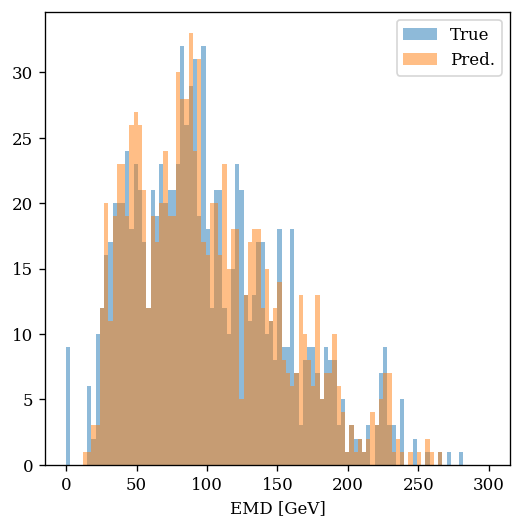

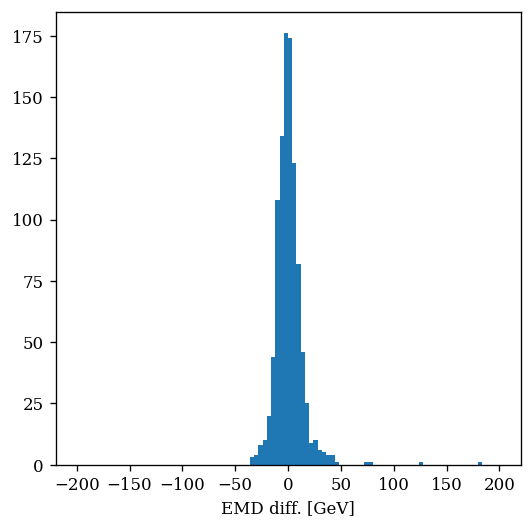

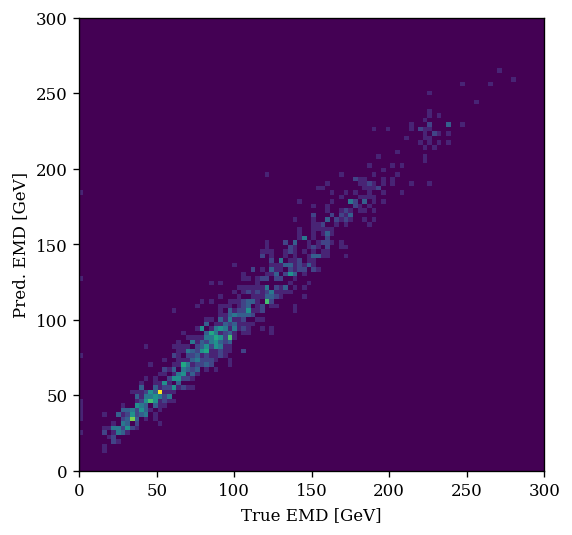

In [11]:
fig, ax = plt.subplots(figsize =(5, 5)) 
plt.hist(ys, bins=np.linspace(0, 300, 101),label='True', alpha=0.5)
plt.hist(preds, bins=np.linspace(0, 300, 101),label = 'Pred.', alpha=0.5)
plt.legend()
ax.set_xlabel('EMD [GeV]') 

fig, ax = plt.subplots(figsize =(5, 5)) 
plt.hist(diffs, bins=np.linspace(-200, 200, 101))
ax.set_xlabel('EMD diff. [GeV]')  

fig, ax = plt.subplots(figsize =(5, 5)) 
x_bins = np.linspace(0, 300, 101)
y_bins = np.linspace(0, 300, 101)
plt.hist2d(ys, preds, bins=[x_bins,y_bins])
ax.set_xlabel('True EMD [GeV]')  
ax.set_ylabel('Pred. EMD [GeV]')